# API Introduction

## What is an API?

API stands for application programming interface, which is a set of definitions and protocols for building and integrating application software.

**Application**
These include the enterprise applications businesses rely on to send financial data, inventory levels, and purchase order information back and forth between suppliers, customers, and trading partners. Consumers and business users alike rely on mobile applications, spending 300 minutes per day on smartphone and tablet apps, according to California-based analytics firm Flurry.

**Programming**
Application creation relies on programming. The application programming interface is developer-centric. In other words, you can’t make a new application without developers, who write the code to create and design the application software and the interface.

**Interface**
The Interface is how software, not users, interacts with other applications.


## What is an API call?
We will use terms like endpoint, call, and client. When an API is utilized, this utilization passes through the system’s exterior through what is known as an endpoint. An endpoint is simply the edge of a system of data that contains a direction to other systems as to how to get what they need. It’s kind of like a road with a large sign saying, “this is where you go in order to get this piece of information.”

Endpoints are typically named by what they do. For example, in our library hypothetical, we might expect the endpoint to be named ```librarySearch```. This endpoint is one of many, but it carries out (at least in an API designed with best practices in mind) a singular function or set of related functions. The ```librarySearch``` endpoint, for example, should contain everything a basic user would need to interact with to find something in the library, be it a book, author, or ISBN.

When this endpoint is interacted with, that interaction is called an “API call”. This interaction doesn’t always involve a person interacting with a system — in fact, it is much more common that an API is interacted with by other APIs, machines, or servers. Regardless of who — or what — is interacting with the system, there are a few common paradigms of interaction. The most common method is through the use of the underlying HTTP verbiage system upon which RESTful (or Representation State Transfer, a paradigm of API design) design is based upon.

Of these verbs, the most common are those that align with CRUD, or Create, Read, Update, and Delete. These roughly correspond to the HTTP verbs ```GET```, ```POST```, ```PUT```, ```PATCH```, and ```DELETE```. These verbs tell the web API exactly what you want to do, how you want to do it, and more importantly, what you expect the state of the interacted resource to be.

- ```GET```: I need you to get some information for me
- ```POST```: I need you to create some information for me
- ```PUT```: I need you to update some existing information
- ```PATCH```: I need you to update a part of some existing information
- ```DELETE```: I need you to remove some existing information

API endpoints are structured to respond to these kinds of interactions with specific responses, attributes, and methods. For instance, ```GET library.com/librarySearch``` will likely result in some information retrieved from the database without any alteration of the data at rest on the server. ```PATCH library.com/librarySearch```, on the other hand, will actually update the data, resulting in a change on the server-side of the data at rest.

## Example API Calls



## Components of a Good API
1. Multiple formats: Different applications speak different languages, including JSON, XML, and CSV.

2. Documentation: This is a no-brainer. Without documentation, no one would know how to use the API. Documentation is the starting point toward making it DevOps friendly.

3. Community: Developers want help… from other developers. In fact, many of the most widely adopted APIs are backed by robust developer communities.

In [1]:
#@title Initialize this Notebook instance
#@markdown ---

#@markdown Loading *packages* and *modules* needed in this notebook. 
#@markdown These are the main python packages used here.
#@markdown * `matplotlib`
#@markdown * `numpy` 
#@markdown * `ipywidgets`
#@markdown * `plotly`
#@markdown * `sympy`
#@markdown * `scipy`

import matplotlib.pyplot as plt
import numpy as np, pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from sympy.solvers import solve as symsolve
from sympy import Symbol
from scipy import integrate

from io import StringIO
import os
import plotly.graph_objects as go
import plotly.express as px
import requests
import json

from google.colab import auth
from oauth2client.client import GoogleCredentials
import gspread

# 7-day US weather forecast

---

Weather forecasting data from [NOAA](https://www.noaa.gov/). NOAA provides 7 day weather forcast using atmospheric models which is calibrated using boundary data from array of weather sensors, satallite data. I am reporting weather forecast data using spacial interpolation from various NOAA weather stations, forecast model and monitoring points. NOAA publishes it's forcasting model in a co-ordinate stencil so spacial interpolation mapping is used to map forecast data to the location(s) of interest.

**Spacial interpolation**

Spatial interpolation works because of [Tobler’s first law of Geography](https://en.wikipedia.org/wiki/Tobler%27s_first_law_of_geography), which states: 
> _“everything is related to everything else, but near things are more related than distant things.”_

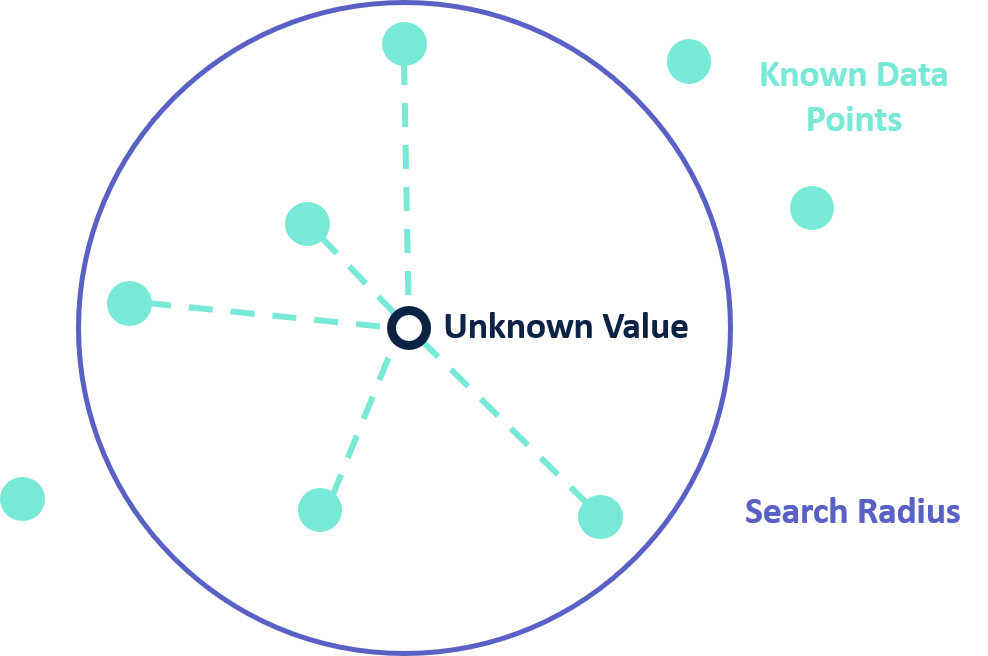

In [2]:
#@title Get NOAA data for a given zip code
#@markdown Use the current weather report from **NOAA** on the core locations

Zip =  96150#@param {type:"integer"}

zip_url = 'https://gist.githubusercontent.com/erichurst/7882666/raw/5bdc46db47d9515269ab12ed6fb2850377fd869e/US%2520Zip%2520Codes%2520from%25202013%2520Government%2520Data'
df_zip = pd.read_csv(zip_url).set_index('ZIP')

noaa_api = 'https://api.weather.gov/points/'

loc = str(df_zip.LAT[int(Zip)]) +\
    ',' + str(df_zip.LNG[int(Zip)])
noaa_url = noaa_api + loc
response = json.loads(requests.get(noaa_url).text)
try:
    new_response = json.loads(requests.get((response['properties'])['forecast']).text)
    Temperature = ((((new_response['properties'])['periods'])[0])['temperature'])
    WindSpeed = float(str.split((((new_response['properties'])['periods'])[0])['windSpeed'])[0])
    print(' ... done.')
except KeyError:
    print('... NOAA API unresponsive for this core, try again.')
name, temperature, wind, forecast, = [], [], [], []
for prop in ((new_response['properties'])['periods']):
    name.append(prop['name'])
    temperature.append(prop['temperature'])
    wind.append(int(prop['windSpeed'].split()[0]))
    forecast.append(prop['shortForecast'])
data_record = pd.DataFrame(
    {
        'T [F]': temperature,
        'Wind [mph]': wind,
        'Forecast': forecast,
    },
    index=name,
)
data_record

 ... done.


,T [F],Wind [mph],Forecast
Tonight,34,5,Chance Rain
Friday,50,15,Rain
Friday Night,26,5,Chance Light Rain then Slight Chance Rain And ...
Saturday,51,5,Chance Rain And Snow
Saturday Night,34,10,Rain Likely
Sunday,51,20,Heavy Rain
Sunday Night,43,25,Heavy Rain
Monday,47,15,Rain
Monday Night,31,10,Light Snow Likely
Tuesday,49,10,Chance Light Snow then Chance Light Rain


In [4]:
#@title Weather pin
#@markdown Put a weather pin in US map. Slide to day you want to see weather prediction pin on.
#@markdown The color of pin is scaled with temperature and size of pin is scaled with the wind speed.

#@markdown ---

Day = 5 #@param {type:"slider", min:0, max:13, step:1}

df_pin = pd.DataFrame(
    {
        'lat': float(loc.split(sep=',')[0]),
        'lon': float(loc.split(sep=',')[1]),
        'Temp': data_record['T [F]'],
        'Wind': data_record['Wind [mph]'],
        'text': data_record['Forecast'],
    },
).reset_index()
df_pin = df_pin.rename(columns={'index': 'day'})

df_sub = df_pin[Day:Day+1]

fig = px.scatter_geo(
    df_sub,
    lat='lat',
    lon='lon',
    text='day',
    locationmode='USA-states',
    color='Temp',
    size='Wind',
    scope='usa',
    title='Weather on ' + df_sub['day'].values[0],
)
fig.show()